# FineST in NPC Visium data

## Main steps

- Step1: Prepare paired image patch and ST spot: Align image pixels with spot coordinates
- Step2: Train model on within spots: Train the model on 80% data and test on 20% data
- Step3: Infer on between spots: Infer gene expression of between spot using trained model
- Step4: Impute on all sub-spots: Impute gene expression using measured gene expression

In [1]:
import os
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import json

# import FineST as fst
# from FineST.datasets import dataset
# import FineST.plottings as fstplt
# print(torch.__version__)
# print("FineST version: %s" %fst.__version__)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
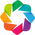

In [2]:
# From GPU2
path = '/mnt/lingyu/nfs_share2/Python/'
os.chdir(str(path) + 'FineST/FineST/')
import FineST as fst
from FineST.datasets import dataset
import FineST.plottings as fstplt

In [3]:
path = '/mnt/lingyu/nfs_share2/Python/'

fst.setup_seed(666)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

colors = ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"]
cnt_color = clr.LinearSegmentedColormap.from_list('magma', colors, N=256)

0.1 Make logging and save model

In [4]:
logging.getLogger().setLevel(logging.INFO)

model_folder = str(path) + 'FineST/FineST_local/Finetune/'
dir_name = model_folder + datetime.now().strftime('%Y%m%d%H%M%S%f')
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    logger = fst.setup_logger(dir_name)

print(dir_name)

/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20241218000647123970


0.2 Load parameter settings

You can use the `parameter_file_path` you set or the optimal parameters obtained from your train and test model for your dataset, but here we use our trained `parameter_file_path` for paper results repeated (saved in `FineST/FineST/Parameter/parameters_NPC_P10125.json`).

In [5]:
parameter_file_path = str(path) + 'FineST/FineST/parameter/parameters_NPC_P10125.json'
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

logger.info("Load parameters:\n" + json.dumps(params, indent=2))

[2024-12-18 00:06:47] INFO - Load parameters:
{
  "n_encoder_hidden_matrix": 256,
  "n_encoder_hidden_image": 128,
  "n_encoder_latent": 128,
  "n_projection_hidden": 256,
  "n_projection_output": 128,
  "batch_size": 200,
  "batch_size_pair": 64,
  "n_encoder_layers": 2,
  "dropout_rate": 0,
  "training_epoch": 50,
  "inital_learning_rate": 0.1,
  "k_nearest_positives": 0,
  "temperature": 0.03
}


## 1. Load ST data and Image embeddings

1.1 Load spatial data

A human Nasopharyngeal carcinoma dataset (NPC_patient_1) from [Gong, et al](https://www.nature.com/articles/s41467-023-37614-6). will be used as a reference dataset, raw_feature_bc_matrix, filtered_feature_bc_matrix, and spatial coordinates (.h5) are publicly available in [GSE200310](https://ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE200310). For easier reuse, we included them in an anndata object which can be loaded directly in FineST Python package.

In [6]:
adata = dataset.NPC()
print(adata)

AnnData object with n_obs × n_vars = 1331 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


1.2 Selected LR genes 

In FineST, we only considers 963 human genes involved in ligand-receptor pairs from [CellChatDB (version.1.1.3)](https://github.com/sqjin/CellChat/tree/master/data) (mouse: 2,022 pairs, human: 1,940 pairs, zebrafish: 2,774 pairs), and extract the overlap gene's expression profile.

In [7]:
LR_gene_path = str(path)+'FineST/FineST/Dataset/LRgene/LRgene_CellChatDB_baseline.csv'
adata = fst.adata_LR(adata, LR_gene_path)
print(adata)

AnnData object with n_obs × n_vars = 1331 × 911
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


1.3 Data preprocess

After making an intersection with the LR genes and filtering out genes that are detected in less than 10 cells, 596 genes from the NPC datasetare used for training and prediction.

In [8]:
adata = fst.adata_preprocess(adata)
print(adata)

gene_hv = np.array(adata.var_names)
matrix = fst.adata2matrix(adata, gene_hv)
matrix

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
(1331, 596)


,TGFB1,TGFBR1,TGFBR2,TGFB2,TGFB3,ACVR1B,ACVR1C,ACVR1,BMP2,BMPR1A,...,KDR,TREM2,SEMA6A,SEMA6B,SEMA7A,PLXNC1,SIGLEC1,THY1,VCAM1,VSIR
,,,,,,,,,,,,,,,,,,,,,
AAACAATCTACTAGCA-1,0.000000,0.000000,0.00000,0.0,0.784856,0.784856,0.0,0.000000,0.000000,0.0000,...,0.0,0.784856,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAACGAAGAACATACC-1,1.538792,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.797351,0.000000,0.0000,...,0.0,0.000000,0.797351,0.0,0.000000,0.000000,0.797351,0.000000,1.235270,0.000000
AAAGGGATGTAGCAAG-1,0.000000,0.481666,0.00000,0.0,0.000000,0.481666,0.0,0.000000,0.000000,0.0000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.481666,1.409484,0.481666
AAAGTCACTGATGTAA-1,0.000000,0.633767,0.00000,0.0,0.000000,1.018628,0.0,0.000000,0.000000,0.0000,...,0.0,0.000000,0.633767,0.0,0.000000,0.000000,0.633767,0.000000,1.512659,0.633767
AAAGTGTGATTTATCT-1,0.501523,0.000000,1.08306,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.501523,0.833982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGGCCCTGACAGT-1,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.888100,0.000000,0.8881,...,0.0,0.000000,0.000000,0.0,0.888100,0.000000,0.000000,0.000000,0.888100,0.888100
TTGTGTTTCCCGAAAG-1,0.890100,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,...,0.0,0.000000,0.000000,0.0,0.540979,0.540979,0.000000,0.540979,0.540979,0.890100
TTGTTAGCAAATTCGA-1,0.457721,0.457721,0.00000,0.0,0.000000,0.457721,0.0,0.457721,0.457721,0.0000,...,0.0,0.000000,0.457721,0.0,0.000000,0.000000,0.000000,0.000000,1.500249,0.457721


1.4 Order by image file name

Load image embedding from **Setp0** `HIPT_image_feature_extract.py`. For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo) (within spots: AH_Patient1_pth_64_16, between spots: NEW_AH_Patient1_pth_64_16, single-nuclei: sc_Patient1_pth_16_16).

In [9]:
file_paths = sorted(os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/'))
print("Image embedding file:", file_paths[:3])

Image embedding file: ['AH_Patient1_10014_10023.pth', 'AH_Patient1_10015_9649.pth', 'AH_Patient1_10016_9276.pth']


In [10]:
## Image patch position
position_image = fst.get_image_coord(file_paths, dataset_class="Visium")
print(position_image.shape)
print(position_image.head())

(1331, 2)
   pixel_x  pixel_y
0    10023    10014
1     9649    10015
2     9276    10016
3     7783    10020
4     7410    10021


In [11]:
## ST spot position
os.chdir(str(path)+'FineST/FineST/Dataset/NPC/patient1/')
position = pd.read_csv('tissue_positions_list.csv', header=None)
position = position.rename(columns={position.columns[-2]: 'pixel_x', 
                                    position.columns[-1]: 'pixel_y'})

In [12]:
## merge position
position_image = fst.image_coord_merge(position_image, position, dataset = 'Visium')
spotID_order = np.array(position_image[0])
print(position_image.shape)
print(position_image.head())

(1331, 6)
                    0  1   x   y  pixel_x  pixel_y
0  GTCGTTATTCGCTTAT-1  1  46  76    10023    10014
1  ACAAGGGCAGGCTCTG-1  1  44  76     9649    10015
2  TGCGTTTGTTGACACT-1  1  42  76     9276    10016
3  TTGAATATGGACTTTC-1  1  34  76     7783    10020
4  CCGGGCGGTCTCGTCA-1  1  32  76     7410    10021


1.5 Order matrix row/barcode, spatial coordinates by image coordinates

In [13]:
matrix_order, matrix_order_df = fst.sort_matrix(matrix, position_image, spotID_order, gene_hv)
matrix_order_df

,TGFB1,TGFBR1,TGFBR2,TGFB2,TGFB3,ACVR1B,ACVR1C,ACVR1,BMP2,BMPR1A,...,KDR,TREM2,SEMA6A,SEMA6B,SEMA7A,PLXNC1,SIGLEC1,THY1,VCAM1,VSIR
GTCGTTATTCGCTTAT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,1.463911,0.0,0.0,1.463911,0.000000,0.000000
ACAAGGGCAGGCTCTG-1,1.543805,0.905412,0.905412,0.0,0.000000,0.000000,0.0,0.000000,0.551857,0.000000,...,0.0,0.000000,0.000000,0.551857,0.551857,0.0,0.0,0.905412,1.543805,0.551857
TGCGTTTGTTGACACT-1,0.000000,0.000000,1.092333,0.0,0.000000,1.092333,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
TTGAATATGGACTTTC-1,0.418937,0.418937,0.713288,0.0,0.418937,0.000000,0.0,0.418937,0.000000,0.418937,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.713288,0.940412,0.000000
CCGGGCGGTCTCGTCA-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.848202,0.848202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTCTGGCCTAGACGG-1,0.000000,0.000000,0.000000,0.0,0.000000,0.432448,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.432448,0.000000,0.000000,0.0,0.0,0.000000,0.964348,0.432448
CAAACTATTGAGCTTC-1,0.925633,0.000000,0.000000,0.0,0.000000,0.925633,0.0,0.000000,0.000000,0.000000,...,0.0,0.925633,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
ACATCGTTAACCTAGT-1,0.682651,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.682651,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.682651,1.084593,1.084593
GTTAGAGTGTGCCGCT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.978859,0.000000,0.000000,0.0,0.0,0.000000,1.250511,0.000000


In [14]:
## save gene expression mateix -- train model used
# np.save(str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/harmony_matrix.npy', matrix_order_df.T)

In [15]:
adata = fst.update_adata_coord(adata, matrix_order, position_image)
print(adata)

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


In [16]:
position_order = fst.update_st_coord(position_image)
position_order

,pixel_y,pixel_x,array_row,array_col
0,10014,10023,76,46
1,10015,9649,76,44
2,10016,9276,76,42
3,10020,7783,76,34
4,10021,7410,76,32
...,...,...,...,...
1326,9922,4237,75,15
1327,9923,3490,75,11
1328,9924,3117,75,9
1329,9925,2743,75,7


In [17]:
## save the position data  -- train model used
# position_order.to_csv(str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order.csv', index=False, header=False)

In [18]:
## save the original adata
# patientxy = 'patient1'
# adata.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_orignal.h5ad')

<div class="alert alert-info">

**Note**
The above cells for `section 1.5` only need to be run once. They aim to generate the ordered gene expression profile `harmony_matrix.npy` and the ordered ST spot coordinates `position_order.csv` according to image pixel coordinates, and save the normalized gene expression data `patient1_adata_orignal.h5ad`. 

</div>

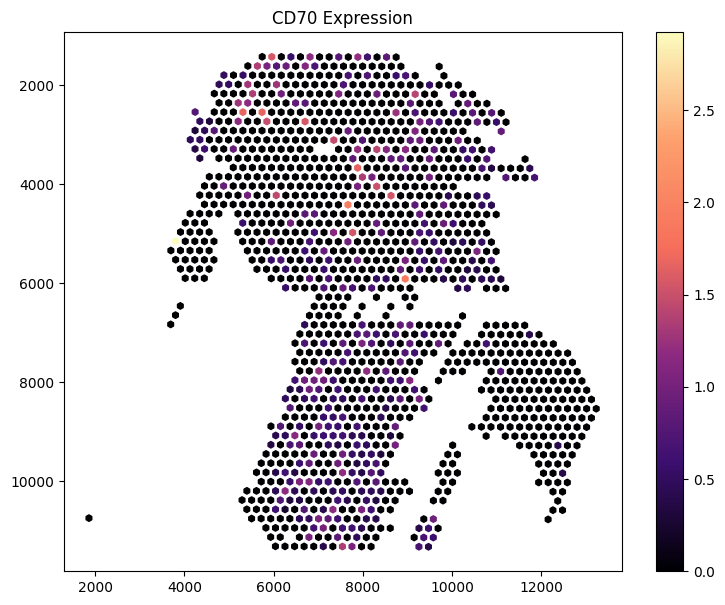

In [19]:
## visualisation
fstplt.gene_expr(adata, matrix_order_df, gene_selet='CD70', save_path=None)

## 2 Train and Test model

2.1 Data loader and splitting: 80% for train and 20% for test

Input: three input file pathway: \
    - `image_embed_path`: image embedding from **Setp0** `HIPT_image_feature_extract.py` \
    - `spatial_pos_path`: ordered ST spot coordinates, can be found in `FineST/Dataset/NPC/ContrastP1geneLR/position_order.csv` \
    - `reduced_mtx_path`: ordered gene expression profile, can be found in `FineST/Dataset/NPC/ContrastP1geneLR/harmony_matrix.np` 

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [20]:
image_embed_path_NPC = str(path)+'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/*.pth'
spatial_pos_path = str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order.csv'
reduced_mtx_path = str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/harmony_matrix.npy'

In [21]:
train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
                                              image_embed_path=image_embed_path_NPC, 
                                              spatial_pos_path=spatial_pos_path, 
                                              reduced_mtx_path=reduced_mtx_path, 
                                              dataset_class='Visium')

***** Building loaders *****
Finished loading all files
train/test split completed
1064 267
***** Finished building loaders *****


In [22]:
all_dataset = fst.build_loaders_inference(batch_size=adata.shape[0], 
                                          image_embed_path=image_embed_path_NPC, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path, 
                                          dataset_class='Visium') 

***** Building loaders_inference *****
Finished loading all files
***** Finished building loaders_inference *****


2.2 Train and test model on within spot

In [23]:
# ## load parameter settings
# with open(parameter_file_path,"r") as json_file:
#     params = json.load(json_file)

# ## add params
# params['n_input_matrix'] = len(gene_hv)
# params['n_input_image'] = 384

# ## init the model
# model = fst.CellContrastModel(n_input_matrix=params['n_input_matrix'],
#                               n_input_image=params['n_input_image'],
#                               n_encoder_hidden_matrix=params["n_encoder_hidden_matrix"],
#                               n_encoder_hidden_image=params["n_encoder_hidden_image"],
#                               n_encoder_latent=params["n_encoder_latent"],
#                               n_projection_hidden=params["n_projection_hidden"],
#                               n_projection_output=params["n_projection_output"],
#                               n_encoder_layers=params["n_encoder_layers"]).to(device) 

# l = fst.ContrastiveLoss(temperature=params['temperature'])
# # print(model)

# ## Set optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=params['inital_learning_rate'], 
#                             momentum=0.9, weight_decay=5e-4)

# ## Load the data
# train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
#                                               image_embed_path=image_embed_path_NPC, 
#                                               spatial_pos_path=spatial_pos_path, 
#                                               reduced_mtx_path=reduced_mtx_path, 
#                                               dataset_class='Visium') 


# ## Train the model for a fixed number of epoch
# logger.info('Begin Training ...')

# start_time = time.time()

# best_loss = float('inf')
# best_epoch = 0
# for epoch in range(params['training_epoch']):
#     logger.info('epoch [{}/{}]'.format(epoch + 1, epoch))
#     print(f"Epoch: {epoch + 1}")
    
#     ######################################################################################
#     # Train the model 
#     ######################################################################################
#     model.train()
#     start_time = time.time()
#     train_loss = fst.train_model(params, model, train_loader, optimizer, epoch, l, 
#                                  tree_type='KDTree', leaf_size=2, dataset_class='Visium')   
#     print("--- %s seconds ---" % (time.time() - start_time))
    
#     ######################################################################################
#     # Evaluate the model 
#     ######################################################################################
#     model.eval()
#     with torch.no_grad():
#         test_loss = fst.test_model(params, model, test_loader, l, 
#                                    tree_type='KDTree', leaf_size=2, dataset_class='Visium') 
    
#     if best_loss > test_loss:
#         best_loss = test_loss
#         best_epoch = epoch

#         fst.save_model(model, dir_name, params, optimizer, train_loss)
#         print("Saved Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))
#         logger.info("Saved Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))

# print("Done!, final loss: {}".format(best_loss))
# print("Best epoch: {}".format(best_epoch))

# print("--- %s seconds ---" % (time.time() - start_time))

# logger.info("Done!, Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))

# logger.info('Finished Training')

<div class="alert alert-info">

**Note**
The above cell for `section 2.2` needs to be run more than once by setting different parameters in the given `.json` file, if the correlation in `section 3.4` is not satisfying. If one obtains a good performance, one can save the `dir_name` and then directly use it to load the trained model and infer gene expression, and doesn't need to run `section 2.2` again. Recommended parameter fine-tuning and its range: `training_epoch`: 40~60; 
`temperature`: 0.01-0.05.

</div>

## 3. Inference, Imputation and Evaluation on within spot

3.1 Infer the gene expression of within spots

In [24]:
dir_name

'/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20241218000647123970'

You can use the `dir_name` just obtained from the above cell, but here we use our trained `dir_name` for paper results repeated (saved in `FineST/FineST/Finetune/20240125140443830148`).

In [25]:
dir_name = str(path)+'FineST/FineST_local/Finetune/20240125140443830148'  

In [26]:
# load params
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

# load models
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)   
model.to(device)

# load all data
test_loader = fst.build_loaders_inference(batch_size=adata.shape[0], 
                                          image_embed_path=image_embed_path_NPC, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path,
                                          dataset_class='Visium')


# inference
logger.info("Running inference tesk...")

start_time = time.time()

(matrix_profile, 
reconstructed_matrix, 
recon_ref_adata_image_f2, 
representation_image_reshape,
representation_matrix,
projection_image_reshape,
projection_matrix,
input_image_exp,
reconstruction_iamge,
reconstructed_matrix_reshaped,
input_coord_all) = fst.perform_inference_image(model, test_loader, dataset_class='Visium')

print("--- %s seconds for inference within spots ---" % (time.time() - start_time))
print("reconstructed_matrix_reshaped shape: ", reconstructed_matrix_reshaped.shape)

logger.info("Running inference tesk DONE!")

***** Building loaders_inference *****


[2024-12-18 00:06:52] INFO - Running inference tesk...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


***** batch_size=adata.shape[0] doen't effect *****
torch.Size([1331, 596])
torch.Size([1331, 16, 384])
1
1
1
***** *****
Finished extractting test data


[2024-12-18 00:06:53] INFO - Running inference tesk DONE!


--- 1.1301994323730469 seconds for inference within spots ---
reconstructed_matrix_reshaped shape:  torch.Size([21296, 596])


3.2 Get coordinates of sub-spots from within spots

We use `reshape_latent_image()` function to convert the super-resolved gene expression with 16X relolution `reconstructed_matrix_reshaped` (torch.Size([21296, 596])) into tensor format `reconstructed_matrix_reshaped_tensor` (torch.Size([1331, 16, 596])).

In [27]:
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium')
print(reconstructed_matrix_reshaped_tensor.shape)

torch.Size([1331, 16, 596])


first_spot_first_variable shape: (16,)


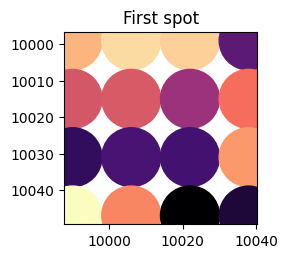

In [28]:
## plot the sub-spot level gene expression of the first gene in the first within spot
(first_spot_first_variable, C, 
 _, _, _) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor, 
                                         adata, gene_hv, p=0, q=0, dataset_class="Visium")
print("first_spot_first_variable shape:", first_spot_first_variable.shape)
fstplt.subspot_expr(C, first_spot_first_variable, save_path=None)

In [29]:
## Get the sub-spot level gene expression of all genes in all within spots
(_, _, all_spot_all_variable, 
 C2, adata_infer) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor, 
                                                adata, gene_hv, dataset_class="Visium")
print("all_spot_all_variable shape:", all_spot_all_variable.shape)
print(adata_infer)

all_spot_all_variable shape: (21296, 596)
AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'


Here, `adata_infer` is the inferred super-resolved gene expression data with 16X solution.

3.3 Impute the gene expression of sub-spots

Input: two files: \
    - `adata`: original spot-level gene expression data (within spots). \
    - `adata_infer`: inferred super-resolved gene expression data (within spots). 

Output: two files: \
    - `adata_impt`: `= w*adata_infer + (1-w)*sudo_adata`, predicted super-resolved gene expression data (here ` w=0.5`), \
    - where`sudo_adata` is the imputed data using the nearest `k` neighbors of within spots (here `k=6`). \
    - ` data_impt`: predicted super-resolved gene expression data in tensor form (within spots).

In [30]:
adata_imput = fst.impute_adata(adata, adata_infer, C2, gene_hv, k=6)
print(adata_imput)

--- 4.654410362243652 seconds ---
AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [31]:
adata_imput, data_impt = fst.weight_adata(adata_infer, adata_imput, gene_hv, w=0.5)
print(data_impt)

tensor([[0.7551, 0.3533, 0.6186,  ..., 1.0142, 1.3170, 0.8148],
        [0.7471, 0.3410, 0.6082,  ..., 1.0618, 1.2832, 0.7946],
        [0.7457, 0.3359, 0.6114,  ..., 1.0620, 1.2369, 0.7854],
        ...,
        [0.8450, 0.3409, 0.4021,  ..., 0.6358, 2.1867, 0.7683],
        [0.8382, 0.3398, 0.3959,  ..., 0.6310, 2.2051, 0.7662],
        [0.8125, 0.3373, 0.3914,  ..., 0.6341, 2.1806, 0.7651]],
       dtype=torch.float64)


For performance evaluation, we integrate super-resolved gene expression `data_impt` into spot-level gene expression `data_impt_reshape` (i.e., from 16x sub-spot level to spot level)

In [32]:
_, data_impt_reshape = fst.reshape_latent_image(data_impt, dataset_class='Visium')
print("data_impt shape:", data_impt.shape)
print("data_impt_reshape shape:", data_impt_reshape.shape)

data_impt shape: torch.Size([21296, 596])
data_impt_reshape shape: torch.Size([1331, 596])


3.4 Visualization: selected gene (Original vs. FineST)

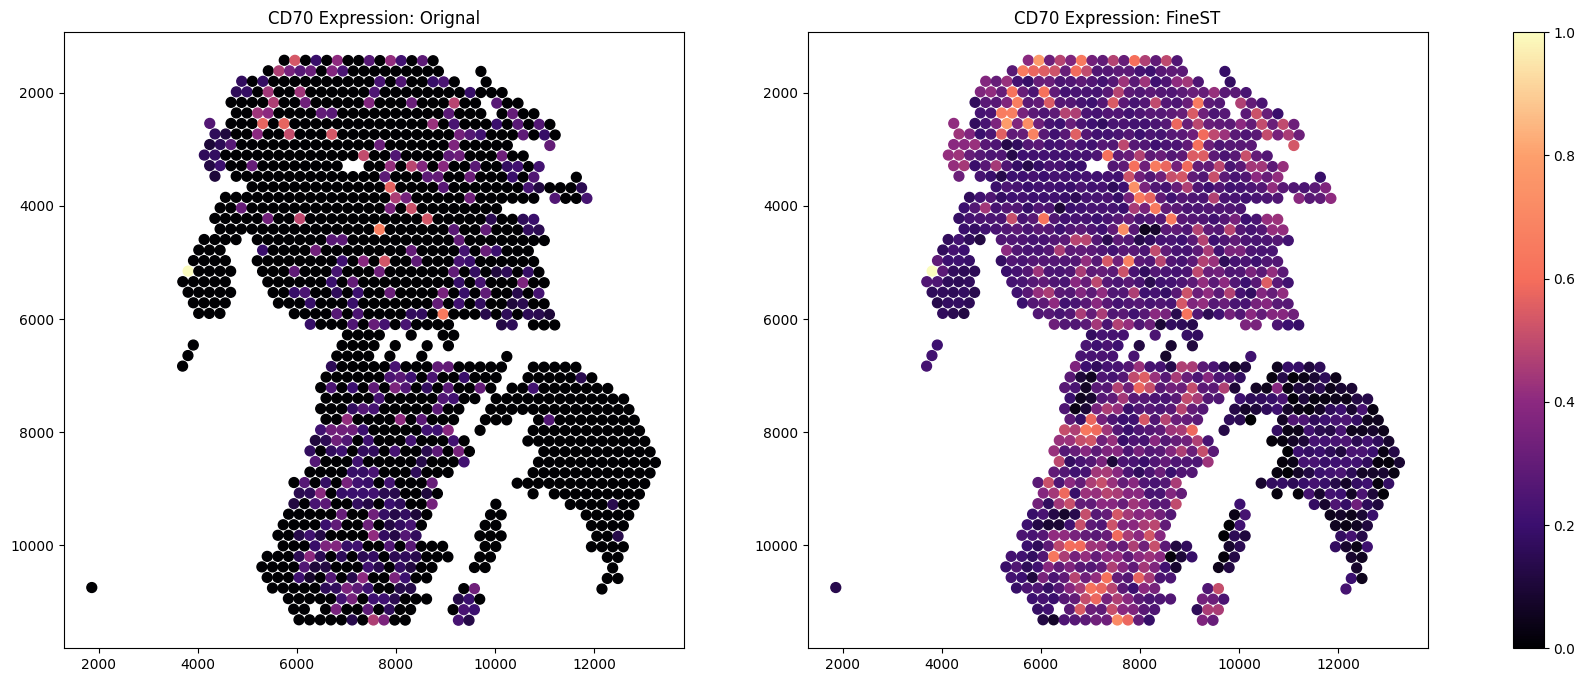

In [33]:
fstplt.gene_expr_compare(adata, "CD70", data_impt_reshape, gene_hv, s=50, save_path=None)

3.4 Correlation: Selected gene、all spots and all genes、mean correlation box

The correlation can be used as a measure to evaluate the gene expression prediction performance. Here we provide three functions: \
    - `sele_gene_cor`: show the selected gene correlation (Reconstructed by FineST vs. Original). \
    - `mean_cor`     : calculate the mean correlation of all spots or all genes. \
    - `mean_cor_box` : box plot of correlation for all spots or all genes.

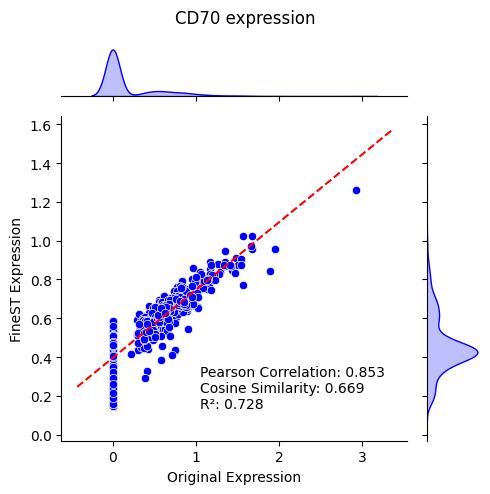

In [34]:
## if ones wants to save the figure in .pdf format, just set: save_path=str(gene)+'correlation.pdf'
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "CD70", 
                     ylabel='FineST Expression', title = "CD70 expression", size=5, 
                     save_path=None)    

In [35]:
logger.info("Running spot correlation task...")

(pearson_cor_spot, 
 spearman_cor_spot, 
 cosine_sim_spot) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="spot")

logger.info("Running spot correlation task DINE!")

[2024-12-18 00:06:59] INFO - Running spot correlation task...


matrix1:  (1331, 596)
matrix2:  (1331, 596)
Mean Pearson correlation coefficient--reconf2: 0.8535


[2024-12-18 00:07:00] INFO - Running spot correlation task DINE!


Mean Spearman correlation coefficient--reconf2: 0.6093
Mean cosine similarity--reconf2: 0.6075


In [36]:
logger.info("Running gene correlation task...")

(pearson_cor_gene, 
 spearman_cor_gene, 
 cosine_sim_gene) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="gene")

logger.info("Running gene correlation task DINE!")

[2024-12-18 00:07:00] INFO - Running gene correlation task...


matrix1:  (1331, 596)
matrix2:  (1331, 596)
Mean Pearson correlation coefficient--reconf2: 0.8845


[2024-12-18 00:07:00] INFO - Running gene correlation task DINE!


Mean Spearman correlation coefficient--reconf2: 0.5380
Mean cosine similarity--reconf2: 0.6075


0.8534651812923978
0.8845136777311445


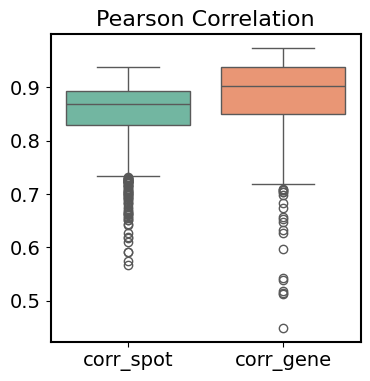

In [37]:
fstplt.mean_cor_box(adata, data_impt_reshape, save_path=None)

In [38]:
## save adata
# patientxy = 'patient1'
# adata_impt.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata.h5ad')

<div class="alert alert-info">

**Note**
Here the `adata_impt` is the imputed spot-level gene expression from FineST, it only contains the given 1331 within spots. The comparisons are based on the original adata `patient1_adata_orignal.h5ad` vs. FineST's predicted adata `patient1_adata.h5ad`.

</div>

## 4. Infer gene expression of "within spot" and "between spot" 

4.1 Get all spot coordinates (within spot & between spot) of image embeddings

Input: two input file pathways: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. 

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [39]:
## add coords for each .pth file
file_paths_spot = os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/')
print("file_paths_spot number: ", len(file_paths_spot))
file_paths_between_spot = os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/NEW_AH_Patient1_pth_64_16/')
print("file_paths_between_spot number:", len(file_paths_between_spot))
file_paths_all = file_paths_spot + file_paths_between_spot
print("file_paths_all number:", len(file_paths_all))

## Merge, sort and process file paths
data_all = fst.get_image_coord_all(file_paths_all, dataset_class='Visium')
position_order_allspot = pd.DataFrame(data_all, columns=['pixel_y', 'pixel_x'])
position_order_allspot

file_paths_spot number:  1331
file_paths_between_spot number: 3708
file_paths_all number: 5039


,pixel_y,pixel_x
0,10014,10023
1,10015,9649
2,10016,9276
3,10020,7783
4,10021,7410
...,...,...
5034,9978.0,3023.5
5035,9978.5,2836.5
5036,9979.0,2650.0
5037,9980.0,2277.0


In [40]:
## save all spots
# position_order_allspot.to_csv(str(path)+"FineST/FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv", index=False, header=False)

<div class="alert alert-info">

**Note**
The above two cells for `section 4.1` only need to be run once, aiming to generate the ordered ST spot coordinates `position_order_all.csv` according to image pixel coordinates.

</div>

4.2 Load all spot image embeddings with their coordinates

Input: three input file pathway: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. \
    - `spatial_pos_path`: ordered all ST spot coordinates from above cell, can be found in `FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv`

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [41]:
import glob
file_paths_spot = str(path)+'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/*.pth'
file_paths_between_spot = str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/NEW_AH_Patient1_pth_64_16/*.pth'
spatial_pos_path=str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order_all.csv'

4.4 Load the trained model to infer all spots

In [42]:
## load params
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

## load models
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)   
model.to(device)
# print("model", model)

## load all spot (within and between) spots data
all_dataset = fst.build_loaders_inference_allimage(batch_size=len(file_paths_all), 
                                                   file_paths_spot=image_embed_path_NPC, 
                                                   file_paths_between_spot=file_paths_between_spot, 
                                                   spatial_pos_path=spatial_pos_path, 
                                                   dataset_class='Visium')

## inference
logger.info("Running inference tesk between spot...")

start_time = time.time()

(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset)

print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
# print("recon_ref_adata_image_f2:\n", recon_ref_adata_image_f2)
# print("input_coord_all:\n", input_coord_all)

logger.info("Running inference tesk between spot DONE!")

***** Building loaders_inference between spot *****


[2024-12-18 00:07:04] INFO - Running inference tesk between spot...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]
[2024-12-18 00:07:04] INFO - Running inference tesk between spot DONE!


***** batch_size=adata.shape[0] *****
torch.Size([5039, 16, 384])
1
***** *****
Finished extractting image_between_spot data
--- 0.31962156295776367 seconds ---
recon_ref_adata_image_f2: (5039, 596)


4.5 Visualization all spots

In [43]:
## process_and_check_duplicates 0f the coordinates of all spots (within and between)
spatial_loc_all = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_all)

Are there any duplicate rows? : False
[[10014.  10023. ]
 [10015.   9649. ]
 [10016.   9276. ]
 ...
 [ 9979.   2650. ]
 [ 9980.   2277. ]
 [ 9980.5  2090.5]]


In [44]:
# fstplt.gene_expr_allspots("CD70", spatial_loc_all, recon_ref_adata_image_f2, gene_hv, 'Inferred all spot', s=4, save_path=None)

4.6 Visualization all sub-spots

In [45]:
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium')
print(reconstructed_matrix_reshaped_tensor.shape)

torch.Size([5039, 16, 596])


In [46]:
## Get the sub-spot level gene expression of all genes in all spots
(_, _, all_spot_all_variable, 
 C2, adata_infer_all) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_all, gene_hv, dataset_class="Visium")
print("all_spot_all_variable shape:", all_spot_all_variable.shape)
print(adata_infer_all)

all_spot_all_variable shape: (80624, 596)
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'


In [47]:
# fstplt.gene_expr_allspots("CD70", C2, all_spot_all_variable, gene_hv, 'Inferred all spot', s=0.5, save_path=None)

## 5. Imputate sub-spot gene expression using measured spot expression

5.1 Impute the gene expression of all sub-spots from all spots (within spots and between spots)

In [48]:
adata_impt_all = fst.impute_adata(adata, adata_infer_all, C2, gene_hv, k=6)
print(adata_impt_all)

--- 18.621765851974487 seconds ---
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [49]:
adata_impt_all, data_impt_all = fst.weight_adata(adata_infer_all, adata_impt_all, gene_hv, w=0.5)
print(data_impt_all)

tensor([[0.7551, 0.3533, 0.6186,  ..., 1.0142, 1.3170, 0.8148],
        [0.7471, 0.3410, 0.6082,  ..., 1.0618, 1.2832, 0.7946],
        [0.7457, 0.3359, 0.6114,  ..., 1.0620, 1.2369, 0.7854],
        ...,
        [0.8020, 0.3202, 0.4338,  ..., 0.6157, 2.3090, 0.7561],
        [0.8029, 0.3104, 0.4460,  ..., 0.6182, 2.2596, 0.7510],
        [0.7863, 0.2985, 0.4466,  ..., 0.6107, 2.1993, 0.7341]],
       dtype=torch.float64)


In [50]:
## save adata: 80624 × 596
# patientxy = 'patient1'
# adata_impt_all.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_all.h5ad')

<div class="alert alert-info">

**Note**
Here, `adata_impt_all` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all.h5ad` contains about 1331x4x16 sub-spots. (1331 within spots, 1331x3 between spots, 16x resolution).

</div>

5.2 Convert super-resolved gene expression to spot-level and save the imputated spot-level adata

In [51]:
_, adata_impt_all_reshape = fst.reshape_latent_image(data_impt_all, dataset_class='Visium')
print("data_impt_all shape:", adata_impt_all.shape)
print("adata_impt_all_reshape shape:", adata_impt_all_reshape.shape)

data_impt_all shape: (80624, 596)
adata_impt_all_reshape shape: torch.Size([5039, 596])


In [52]:
adata_impt_spot = sc.AnnData(X = pd.DataFrame(adata_impt_all_reshape.cpu().detach().numpy()))
adata_impt_spot.var_names = gene_hv
adata_impt_spot.obs['x'] = spatial_loc_all[:,0]
adata_impt_spot.obs['y'] = spatial_loc_all[:,1]

print("adata_impt_spot: ", adata_impt_spot)
print(adata_impt_spot.obs['x'])

adata_impt_spot:  AnnData object with n_obs × n_vars = 5039 × 596
    obs: 'x', 'y'
0       10014.0
1       10015.0
2       10016.0
3       10020.0
4       10021.0
         ...   
5034     9978.0
5035     9978.5
5036     9979.0
5037     9980.0
5038     9980.5
Name: x, Length: 5039, dtype: float64


In [53]:
## save data: 5039 × 596
# patientxy = 'patient1'
# adata_impt_spot.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_all_spot.h5ad')

<div class="alert alert-info">

**Note**
Here, `adata_impt_spot` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all_spot.h5ad` contains about 1331x4 spots. (1331 within spots, 1331x3 between spots), it is integrated from `patient1_adata_all.h5ad` using the `reshape_latent_image` function.

</div>

5.3 Visualization: gene at all spot

CD70 gene expression dim: (5039, 1)
CD70 gene expression: 
 [[0.31857272]
 [0.38838257]
 [0.3760277 ]
 ...
 [0.49542667]
 [0.55092828]
 [0.54530712]]


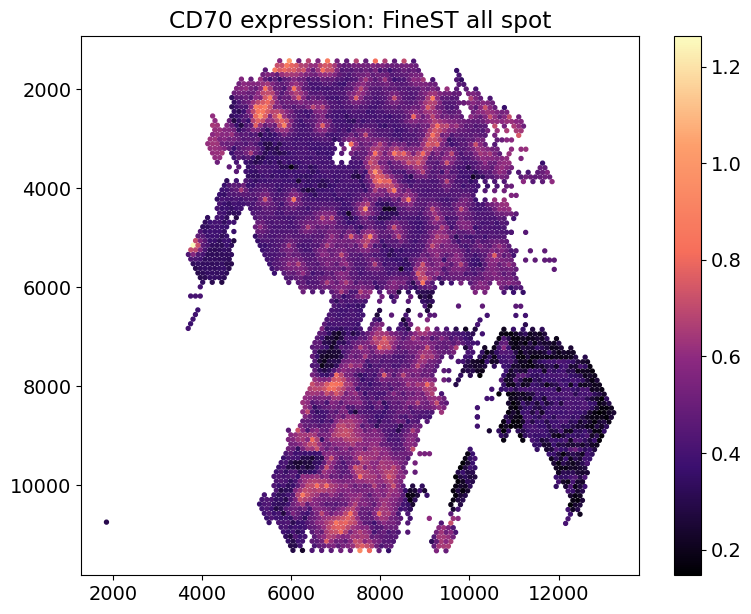

In [54]:
fstplt.gene_expr_allspots("CD70", spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', s=8, save_path=None)

5.4 Visualization: gene at all sub-spot

CD70 gene expression dim: (80624, 1)
CD70 gene expression: 
 [[0.2771624 ]
 [0.26723772]
 [0.25254893]
 ...
 [0.60330289]
 [0.59376435]
 [0.58118813]]


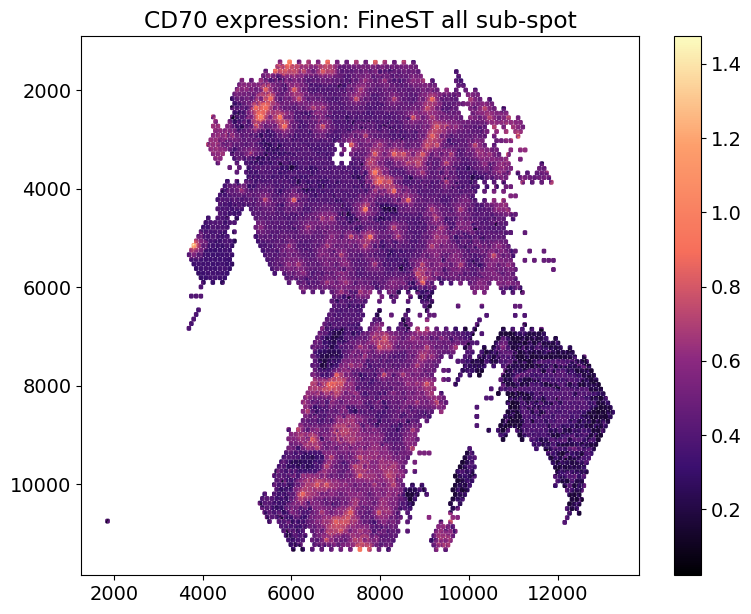

In [55]:
fstplt.gene_expr_allspots("CD70", C2, adata_impt_all.X, gene_hv, 
                          'FineST all sub-spot', s=0.5, save_path=None)

## 6. Infer and impute gene expression at "single-cell" level

<div class="alert alert-info">

**Note**
Section 6 directly infers super-resolved gene expression based on image features from ``nuclei segmentation``. The framework is similar to Section 3-5.
</div>

6.1 Infer the gene expression of at single-cell resolution

In [56]:
dir_name

'/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20240125140443830148'

You can use the `dir_name` just obtained from Section 2 (Model training), but just like Section 3, here we use our trained `dir_name` for paper results repeated (saved in `FineST/FineST/Finetune/20240125140443830148`).

In [57]:
dir_name = str(path)+'FineST/FineST_local/Finetune/20240125140443830148'  

In [58]:
file_paths_sc = sorted(os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/sc_Patient1_pth_16_16/'))
print("Image embedding file: \n", file_paths_sc[:3])

Image embedding file: 
 ['sc_Patient1_10000.091130137822_6973.0.pth', 'sc_Patient1_10000.88115707885_8121.0.pth', 'sc_Patient1_10001.390627018023_8271.730275425016.pth']


In [59]:
## Image patch position
data_all_sc = fst.get_image_coord_all(file_paths_sc, dataset_class="Visium")
spatial_loc_sc = pd.DataFrame(data_all_sc, columns=['pixel_y', 'pixel_x'])
spatial_loc_sc = spatial_loc_sc[['pixel_x', 'pixel_y']]
print(spatial_loc_sc) 

                  pixel_x             pixel_y
0                  6973.0  10000.091130137822
1                  8121.0   10000.88115707885
2       8271.730275425016  10001.390627018023
3                 12037.0             10004.0
4                 12069.0             10004.0
...                   ...                 ...
40063              9677.0              9998.0
40064  10091.765254114129              9999.0
40065              9784.0              9999.0
40066   9957.435720606743              9999.0
40067    6258.66041050717   9999.263061138892

[40068 rows x 2 columns]


In [60]:
len(file_paths_sc)

40068

In [61]:
## save .csv file
# spatial_loc_sc.to_csv(str(path)+"FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order_sc.csv", 
#                       index=False, header=False)

Input: three input file pathway: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. \
    - `spatial_pos_path`: ordered all ST spot coordinates from above cell, can be found in `FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv`

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [62]:
import glob
image_embed_path_sc = str(path)+'NPC/Data/stdata/ZhuoLiang/LLYtest/sc_Patient1_pth_16_16/*.pth'
spatial_pos_path_sc=str(path)+'FineST/FineST_local/Dataset/NPC/ContrastP1geneLR/position_order_sc.csv'

In [63]:
## load params
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

## load models
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)   
model.to(device)

## load all data
all_dataset_sc = fst.build_loaders_inference_allimage(batch_size=len(file_paths_sc),
                                                   file_paths_spot=image_embed_path_sc, 
                                                   spatial_pos_path=spatial_pos_path_sc, 
                                                   dataset_class='VisiumSC')

## inference
logger.info("Running inference tesk single-nuclei...")

start_time = time.time()

(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset_sc, dataset_class='VisiumSC')

print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
print("recon_ref_adata_image_f2:\n", recon_ref_adata_image_f2)
# print("input_coord_all:\n", input_coord_all)

logger.info("Running inference tesk single-nuclei DONE!")

***** Building loaders_inference sc image *****


[2024-12-18 00:07:38] INFO - Running inference tesk single-nuclei...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]
[2024-12-18 00:07:40] INFO - Running inference tesk single-nuclei DONE!


***** batch_size=adata.shape[0] *****
torch.Size([40068, 1, 384])
1
***** *****
Finished extractting image_between_spot data
--- 1.4112329483032227 seconds ---
recon_ref_adata_image_f2: (40068, 596)
recon_ref_adata_image_f2:
 [[1.161243   0.5476292  0.79607904 ... 1.036505   2.6299121  1.3171142 ]
 [1.0571723  0.5507557  0.669859   ... 1.0171349  2.8605523  1.3112675 ]
 [1.0550184  0.5492229  0.6687998  ... 1.0154207  2.8557167  1.3085892 ]
 ...
 [1.1540647  0.5677861  0.7501486  ... 1.0582467  2.8482776  1.3494068 ]
 [1.3303453  0.56836426 1.0353496  ... 1.1243348  2.4566467  1.4029057 ]
 [1.0578504  0.55105406 0.67033076 ... 1.0169482  2.8592234  1.3108226 ]]


In [64]:
spatial_loc_sc = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_sc.shape)
spatial_loc_sc

Are there any duplicate rows? : False
(40068, 2)


array([[ 6973.        , 10000.09113014],
       [ 8121.        , 10000.88115708],
       [ 8271.73027543, 10001.39062702],
       ...,
       [ 9784.        ,  9999.        ],
       [ 9957.43572061,  9999.        ],
       [ 6258.66041051,  9999.26306114]])

In [65]:
# fstplt.gene_expr_allspots("CD70", spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
#                           'Inferred single-cell', s=0.5, save_path=None)

In [66]:
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='VisiumSC')
print(reconstructed_matrix_reshaped_tensor.shape)

torch.Size([40068, 1, 596])


In [67]:
(_, _, all_spot_all_variable, 
 C2, adata_infer_sc) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_sc, gene_hv, dataset_class="VisiumSC")
print("all_spot_all_variable shape:", all_spot_all_variable.shape)
print(adata_infer_sc)

all_spot_all_variable shape: (40068, 596)
AnnData object with n_obs × n_vars = 40068 × 596
    obs: 'x', 'y'


In [68]:
adata_impt_sc = fst.impute_adata(adata, adata_infer_sc, C2, gene_hv, k=6)
print(adata_impt_sc)

--- 8.850650787353516 seconds ---
AnnData object with n_obs × n_vars = 40068 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [69]:
adata_impt_sc, data_impt_sc = fst.weight_adata(adata_infer_sc, adata_impt_sc, gene_hv, w=0.5)
print(data_impt_sc)

tensor([[0.7458, 0.3376, 0.5439,  ..., 0.7785, 1.6751, 1.0367],
        [0.6388, 0.3571, 0.5429,  ..., 0.5389, 1.5722, 0.7811],
        [0.8078, 0.3899, 0.5291,  ..., 0.5077, 1.6333, 0.8765],
        ...,
        [0.6704, 0.3607, 0.6744,  ..., 0.6627, 1.7678, 0.8456],
        [0.7999, 0.3789, 0.7164,  ..., 0.8510, 1.3841, 0.8840],
        [0.8097, 0.2755, 0.5383,  ..., 0.7139, 1.7299, 0.8622]],
       dtype=torch.float64)


In [70]:
## save adata
# adata_impt_sc.write_h5ad(str(path)+'FineST/FineST_local/Dataset/ImputData/patient1/_adata_all_sc.h5ad')

In [71]:
_, adata_impt_sc_reshape = fst.reshape_latent_image(data_impt_sc, dataset_class='VisiumSC')
print("data_impt_sc shape:", adata_impt_sc.shape)
print("adata_impt_sc_reshape shape:", adata_impt_sc_reshape.shape)

data_impt_sc shape: (40068, 596)
adata_impt_sc_reshape shape: torch.Size([40068, 596])


CD70 gene expression dim: (40068, 1)
CD70 gene expression: 
 [[0.5578962 ]
 [0.57687315]
 [0.6671306 ]
 ...
 [0.38637161]
 [0.27552047]
 [0.61062639]]


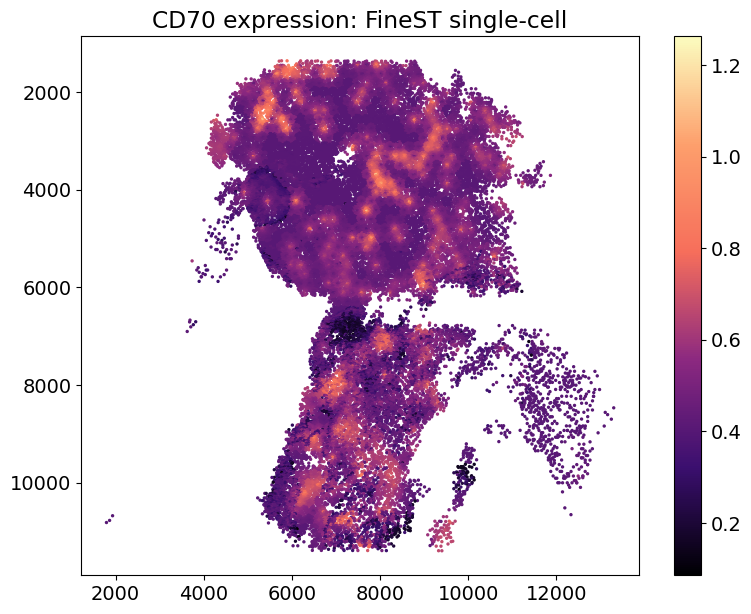

In [72]:
fstplt.gene_expr_allspots("CD70", spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=2, save_path=None)

<div class="alert alert-info">

**Note**
For NPC dataset, the the above four `.h5ad` adata files can be downloaded from [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).
</div>